# Synthetic Time-Series Generation: _VAE-LSTM Hybrid architecture with TensorFlow & GradientTape_

- Based on __Anomaly Detection for Time Series Using VAE-LSTM Hybrid Model__ research paper by Shuyu Lin et al.

- The [Household Power Consumption dataset](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) is a multivariate time series dataset that describes the electricity consumption for a single household over four years.

- The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

- It is a multivariate series comprised of seven variables (besides the date and time); they are:

    - global_active_power: The total active power consumed by the household (kilowatts).
    - global_reactive_power: The total reactive power consumed by the household (kilowatts).
    - voltage: Average voltage (volts).
    - global_intensity: Average current intensity (amps).
    - sub_metering_1: Active energy for kitchen (watt-hours of active energy).
    - sub_metering_2: Active energy for laundry (watt-hours of active energy).
    - sub_metering_3: Active energy for climate control systems (watt-hours of active energy).


In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import LSTM, GRU, Input, Flatten, Dense, LSTM, RepeatVector
from tensorflow.keras.layers import Bidirectional, TimeDistributed, Dropout
from tensorflow.keras.layers import Conv1D, ConvLSTM2D, MaxPooling1D
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.io import loadmat
import scipy
from scipy.fftpack import fft
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly
# import plotly.express as px
import pickle

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-06-06 14:12:10.993698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 14:12:11.028101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 14:12:11.028379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 14:12:11.029282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# path_to_file = "D:/Deep_Learning_resources/Sequence_Modelling_resources/Datasets/Household_Power_Consumption-files/"
path_to_file = "../Seq2Seq_Modeling/Datasets/"

In [6]:
# Read in dataset-
# data = pd.read_csv(path_to_file + "household_power_consumption_cleaned.csv", low_memory = False)
data = pd.read_csv(path_to_file + "household_power_consumption_cleaned.csv", low_memory = False)

In [7]:
data.shape

(2075259, 9)

In [8]:
data.dtypes

datetime                  object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
sub_metering_4           float64
dtype: object

In [9]:
# Convert 'date_time' attribute to datetime, sort & reset indices-
data['datetime'] = pd.to_datetime(data['datetime'])
data.sort_values(by = 'datetime', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [10]:
# Sanity check-
data.dtypes

datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
sub_metering_4                  float64
dtype: object

In [11]:
# Sanity check-
data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [12]:
print(f"min date time: {data['datetime'].min()} & max: {data['datetime'].max()}")

min date time: 2006-12-16 17:24:00 & max: 2010-11-26 21:02:00


In [13]:
# Check for missing values-
data.isna().values.any()

False

In [14]:
data.isna().sum().sum()

0

In [15]:
# Get min and max values for all numeric features-
for col in data.columns.tolist():
    if col == 'datetime':
        continue
    else:
        print(f"{col}; min = {data[col].min():.4f} & max = {data[col].max():.4f}")

Global_active_power; min = 0.0760 & max = 11.1220
Global_reactive_power; min = 0.0000 & max = 1.3900
Voltage; min = 223.2000 & max = 254.1500
Global_intensity; min = 0.2000 & max = 48.4000
Sub_metering_1; min = 0.0000 & max = 88.0000
Sub_metering_2; min = 0.0000 & max = 80.0000
Sub_metering_3; min = 0.0000 & max = 31.0000
sub_metering_4; min = -2.4000 & max = 124.8333


In [16]:
# Specify hyper-parameters-
num_epochs = 100
batch_size = 256

#### Scale dataset

Due to _VAE_, use a min-max scaler in the range [-1, 1].

In [17]:
# Use Min-max scaler-
mm_scaler = MinMaxScaler(feature_range = (-1, 1))
data_scaled = mm_scaler.fit_transform(data.values[:, 1:])

In [18]:
# Sanity check-
data_scaled.shape, data.iloc[:,  1:].shape

((2075259, 8), (2075259, 8))

In [19]:
# Convert to float-32 values-
data_scaled = data_scaled.astype('float32')

In [20]:
# Sanity check-
for col in range(data_scaled.shape[1]):
    print(f"{col}; min = {data_scaled[:, col].min():.4f} &"
          f" max = {data_scaled[:, col].max():.4f}")

0; min = -1.0000 & max = 1.0000
1; min = -1.0000 & max = 1.0000
2; min = -1.0000 & max = 1.0000
3; min = -1.0000 & max = 1.0000
4; min = -1.0000 & max = 1.0000
5; min = -1.0000 & max = 1.0000
6; min = -1.0000 & max = 1.0000
7; min = -1.0000 & max = 1.0000


#### Split dataset in training and testing sets: _90:10_ split

In [21]:
# Split data into training and validation datasets. Ratio is
# 90:10-
len(data_scaled[: int(len(data_scaled) * 0.9)]), len(data_scaled[int(len(data_scaled) * 0.9): ])

(1867733, 207526)

In [22]:
# Sanity check-
len(data_scaled[: int(len(data_scaled) * 0.9)]) + len(data_scaled[int(len(data_scaled) * 0.9): ]) == len(data_scaled)

True

In [23]:
train_data = data_scaled[: int(len(data_scaled) * 0.9), :]
test_data = data_scaled[int(len(data_scaled) * 0.9):, :]

In [24]:
# Sanity check-
train_data.shape, test_data.shape

((1867733, 8), (207526, 8))

In [25]:
# Further sanity check-
train_data[-5:, :]

array([[-0.96451205, -0.8417266 ,  0.26785138, -0.9585062 , -1.        ,
        -1.        , -1.        , -0.89101386],
       [-0.96487415, -0.8446043 ,  0.2187399 , -0.9585062 , -1.        ,
        -1.        , -0.9354839 , -0.907257  ],
       [-0.96487415, -0.8417266 ,  0.273021  , -0.9585062 , -1.        ,
        -1.        , -0.9354839 , -0.907257  ],
       [-0.96487415, -0.8417266 ,  0.26979   , -0.9585062 , -1.        ,
        -1.        , -1.        , -0.89153785],
       [-0.96451205, -0.83884895,  0.3098546 , -0.9585062 , -1.        ,
        -1.        , -0.9354839 , -0.90673304]], dtype=float32)

In [26]:
test_data[:5, :]

array([[-0.95292413, -0.7438849 ,  0.28659126, -0.9419087 , -1.        ,
        -1.        , -0.9354839 , -0.88996595],
       [-0.9511135 , -0.69208634,  0.26138934, -0.9419087 , -1.        ,
        -1.        , -1.        , -0.8716269 ],
       [-0.9511135 , -0.6892086 ,  0.28723747, -0.9419087 , -1.        ,
        -1.        , -0.9354839 , -0.8873461 ],
       [-0.9507514 , -0.68345326,  0.3260097 , -0.9419087 , -1.        ,
        -1.        , -0.9354839 , -0.8868221 ],
       [-0.9511135 , -0.68345326,  0.3473344 , -0.9419087 , -1.        ,
        -1.        , -1.        , -0.8716269 ]], dtype=float32)

In [27]:
data_scaled[1867728:1867738, :]

array([[-0.96451205, -0.8417266 ,  0.26785138, -0.9585062 , -1.        ,
        -1.        , -1.        , -0.89101386],
       [-0.96487415, -0.8446043 ,  0.2187399 , -0.9585062 , -1.        ,
        -1.        , -0.9354839 , -0.907257  ],
       [-0.96487415, -0.8417266 ,  0.273021  , -0.9585062 , -1.        ,
        -1.        , -0.9354839 , -0.907257  ],
       [-0.96487415, -0.8417266 ,  0.26979   , -0.9585062 , -1.        ,
        -1.        , -1.        , -0.89153785],
       [-0.96451205, -0.83884895,  0.3098546 , -0.9585062 , -1.        ,
        -1.        , -0.9354839 , -0.90673304],
       [-0.95292413, -0.7438849 ,  0.28659126, -0.9419087 , -1.        ,
        -1.        , -0.9354839 , -0.88996595],
       [-0.9511135 , -0.69208634,  0.26138934, -0.9419087 , -1.        ,
        -1.        , -1.        , -0.8716269 ],
       [-0.9511135 , -0.6892086 ,  0.28723747, -0.9419087 , -1.        ,
        -1.        , -0.9354839 , -0.8873461 ],
       [-0.9507514 , -0.68345326

In [28]:
def split_series_multivariate(data, n_past, n_future):
    '''
    Create training and testing splits required by Seq2Seq
    architecture(s) for multivariate, multistep and multivariate
    output time-series modeling.
    '''
    X, y = list(), list()
    
    for window_start in range(len(data)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(data):
            break
            
        # slice past and future parts of window-
        past, future = data[window_start: past_end, :], data[past_end: future_end, :]
        # past, future = data[window_start: past_end, :], data[past_end: future_end, 4]
        X.append(past)
        y.append(future)
        
    return np.array(X), np.array(y)


In [ ]:
"""
def split_series_univariate(data, n_past, n_future):
    '''
    Create training and testing splits required by Seq2Seq
    architecture(s) for multivariate, multistep output
    time-series modeling.
    '''
    X, y = list(), list()
    
    for window_start in range(len(data)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(data):
            break
            
        # slice past and future parts of window-
        # past, future = data[window_start: past_end, :], data[past_end: future_end, :]
        past, future = data[window_start: past_end, :], data[past_end: future_end, 0]
        X.append(past)
        y.append(future)
        
    return np.array(X), np.array(y)
"""

### NOTE: This data reshaping is required _only for LSTM and not for VAE!_

In [29]:
# Define hyper-parameters for Seq2Seq modeling:

# look-back window size-
n_past = 30

# number of future steps to predict for-
n_future = 10

# number of features used-
n_features = 8

In [30]:
# Split into training and testing sets for supervised task-
X_train, y_train = split_series_multivariate(train_data, n_past, n_future)
X_test, y_test = split_series_multivariate(test_data, n_past, n_future)

In [31]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (1867694, 30, 8), y_train.shape: (1867694, 10, 8)
X_test.shape: (207487, 30, 8), y_test.shape: (207487, 10, 8)


In [ ]:
# X_train.reshape((X_train.shape[0], X_train.shape[1], n_features)).shape, y_train.reshape((y_train.shape[0], y_train.shape[1], n_features)).shape
# X_test.reshape((X_test.shape[0], X_test.shape[1], n_features)).shape, y_test.reshape((y_test.shape[0], y_test.shape[1], n_features)).shape

In [32]:
# Create TF train and test dataset to iterate over-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size = batch_size, drop_remainder = True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size = batch_size, drop_remainder = True)

2022-06-06 14:13:53.170349: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-06 14:13:53.171769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 14:13:53.171991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 14:13:53.172165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
# Sanity check-
# x, y = next(iter(train_dataset))
# x.shape, y.shape
# (TensorShape([256, 30, 8]), TensorShape([256, 10, 8]))

In [ ]:
# x, y = next(iter(test_dataset))
# x.shape, y.shape
# (TensorShape([256, 30, 8]), TensorShape([256, 10, 8]))

In [ ]:
# del x, y

In [33]:
print(f"One training epoch has {int(X_train.shape[0] / batch_size)} steps and"
      f" one validation epoch has {int(X_test.shape[0] / batch_size)} steps"
     )

One training epoch has 7295 steps and one validation epoch has 810 steps


### Proposed architecture:

__VAE_encoder → VAE latent space → LSTM encoder → LSTM decoder → VAE decoder__

In [34]:
class VAE_Encoder(Model):
    def __init__(self, latent_space = 7):
        super(VAE_Encoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(
            units = 100, activation = None
        )
        self.dense2 = Dense(
            units = 50, activation = None
        )
        self.dense3 = Dense(
            units = 20, activation = None
        )
        self.encoder_output = Dense(
            units = self.latent_space, activation = None
        )
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.,
            stddev = 1.
        )
        return (eps * tf.exp(logvar * 0.5)) + mu
        
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = tf.keras.activations.relu(self.dense3(x))
        x = tf.keras.activations.relu(self.encoder_output(x))
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.dense(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.dense2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.dense3(x)
        print(f"dense3 output shape: {x.shape}")
        x = self.encoder_output(x)
        print(f"Encoder output shape: {x.shape}")
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        print(f"mu.shape: {mu.shape}, log-var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        del x
        return None
    

In [35]:
class VAE_Decoder(Model):
    def __init__(self, latent_space = 7):
        super(VAE_Decoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(units = self.latent_space, activation = None)
        self.dense2 = Dense(units = 20, activation = None)
        self.dense3 = Dense(units = 50, activation = None)
        self.dense4 = Dense(units = 100, activation = None)
        self.decoder_output = Dense(units = n_features, activation = None)
    
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = tf.keras.activations.relu(self.dense3(x))
        x = tf.keras.activations.relu(self.dense4(x))
        x = self.decoder_output(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.dense(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.dense2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.dense3(x)
        print(f"dense3 output shape: {x.shape}")
        x = self.dense4(x)
        print(f"dense4 output shape: {x.shape}")
        x = self.dense5(x)
        print(f"dense5 output shape: {x.shape}")
        x = self.decoder_output(x)
        print(f"Decoder output shape: {x.shape}")
        del x
        return None
    

In [36]:
class LSTM_Encoder(Model):
    '''
    LSTM Encoder definition for Multivariate, Multistep
    Multivariate time-series prediction.
    '''
    def __init__(self):
        super(LSTM_Encoder, self).__init__()
        self.lstm1 = LSTM(
            units = 256, activation = tf.keras.activations.tanh,
            return_sequences = False, return_state = False,
            recurrent_activation = 'sigmoid', use_bias = True,
            input_shape = (n_past, n_features)
        )
        self.repeat_vector = RepeatVector(n = n_future)
    
    
    def call(self, x):
        x = self.lstm1(x)
        x = self.repeat_vector(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.lstm1(x)
        print(f"First LSTM output shape: {x.shape}")
        x = self.repeat_vector(x)
        print(f"Repeat Vector output shape: {x.shape}")
        del x
        return None
    
    

In [37]:
class LSTM_Decoder(Model):
    '''
    LSTM Decoder definition for Multivariate, Multistep
    Multivariate time-series prediction.
    '''
    def __init__(self):
        super(LSTM_Decoder, self).__init__()
        self.lstm1 = LSTM(
            units = 256, activation  = tf.keras.activations.tanh,
            return_sequences = True, return_state = False
        )
        self.time_distributed1 = TimeDistributed(
            Dense(units = 128, activation = tf.keras.activations.relu)
        )
        # Here, 7 is the VAE latent space dimensionality-
        self.time_distributed2 = TimeDistributed(
            Dense(units = 7, activation = None)
        )

    
    def call(self, x):
        x = self.lstm1(x)
        x = self.time_distributed1(x)
        x = self.time_distributed2(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.lstm1(x)
        print(f"First LSTM output shape: {x.shape}")
        x = self.time_distributed1(x)
        print(f"First TimeDistributed output shape: {x.shape}")
        x = self.time_distributed2(x)
        print(f"Second TimeDistributed output shape: {x.shape}")
        del x
        return None
    

In [38]:
class VAE_LSTM(Model):
    def __init__(self, latent_space = 7):
        super(VAE_LSTM, self).__init__()
        self.latent_space = latent_space
        
        # Initialize a VAE encoder & decoder-
        self.model_vae_enc = VAE_Encoder(latent_space = self.latent_space)
        self.model_vae_dec = VAE_Decoder(latent_space = self.latent_space)
        
        # Initialize LSTM encoder and decoder-
        self.model_lstm_enc = LSTM_Encoder()
        self.model_lstm_dec = LSTM_Decoder()
        
    
    def call(self, x):
        # Reshape 3D input to 2D for VAE encoder-
        x = tf.reshape(tensor = x, shape = (batch_size * n_past, n_features))
        
        # Get VAE encoder's outputs-
        x_enc, mu, log_var = self.model_vae_enc(x)
        
        # Reshape from 2D to 3D for LSTM encoder-
        x_enc = tf.reshape(tensor = x_enc, shape = (batch_size, n_past, 7))

        # Get LSTM encoder output-
        x_enc_lstm = self.model_lstm_enc(x_enc)

        # Get LSTM decoder output-
        x_dec_lstm = self.model_lstm_dec(x_enc_lstm)

        # Reshape 3D LSTM decoder to 2D for VAE decoder-
        x_dec_lstm = tf.reshape(tensor = x_dec_lstm, shape = (batch_size * n_future, 7))
        
        # Get VAE decoder output-
        y_pred = self.model_vae_dec(x_dec_lstm)
        
        # Reshape 2D VAE decoder's output to 3D for true labels-
        y_pred = tf.reshape(tensor = y_pred, shape = (batch_size, n_future, n_features))

        return y_pred, mu, log_var
        

In [39]:
# Initialize VAE-LSTM model-
model = VAE_LSTM(latent_space = 7)

In [40]:
# Get a batch of training data-
x, y = next(iter(train_dataset))

In [41]:
# Get predictions from model-
y_pred, mu, log_var = model(x)

2022-06-06 14:14:10.424395: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-06 14:14:10.507967: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


In [42]:
# Sanity check-
y_pred.shape, y.shape

(TensorShape([256, 10, 8]), TensorShape([256, 10, 8]))

In [43]:
mu.shape, log_var.shape

(TensorShape([7680, 7]), TensorShape([7680, 7]))

In [48]:
del x, y, y_pred, mu, log_var

In [44]:
# Get model summary-
model.summary()

Model: "vae_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae__encoder (VAE_Encoder)  multiple                  7229      
                                                                 
 vae__decoder (VAE_Decoder)  multiple                  7174      
                                                                 
 lstm__encoder (LSTM_Encoder  multiple                 270336    
 )                                                               
                                                                 
 lstm__decoder (LSTM_Decoder  multiple                 559111    
 )                                                               
                                                                 
Total params: 843,850
Trainable params: 843,850
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Manually count number of trainable parameters-
tot_trainable_params = 0
for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_trainable_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} trainable parameters")

layer: (8, 100) has 800 trainable parameters
layer: (100,) has 0 trainable parameters
layer: (100, 50) has 5000 trainable parameters
layer: (50,) has 0 trainable parameters
layer: (50, 20) has 1000 trainable parameters
layer: (20,) has 0 trainable parameters
layer: (20, 7) has 140 trainable parameters
layer: (7,) has 0 trainable parameters
layer: (7, 7) has 49 trainable parameters
layer: (7,) has 0 trainable parameters
layer: (7, 7) has 49 trainable parameters
layer: (7,) has 0 trainable parameters
layer: (7, 7) has 49 trainable parameters
layer: (7,) has 0 trainable parameters
layer: (7, 20) has 140 trainable parameters
layer: (20,) has 0 trainable parameters
layer: (20, 50) has 1000 trainable parameters
layer: (50,) has 0 trainable parameters
layer: (50, 100) has 5000 trainable parameters
layer: (100,) has 0 trainable parameters
layer: (100, 8) has 800 trainable parameters
layer: (8,) has 0 trainable parameters
layer: (7, 1024) has 7168 trainable parameters
layer: (256, 1024) has 262

In [46]:
print(f"Total trainable parameters (not counting 0 biases) = {tot_trainable_params}")

Total trainable parameters (not counting 0 biases) = 841803


#### Define loss function for _Seq2Seq + VAE_ architecture

Note that _reconstruction_ loss and _KL-divergence_ loss are inversely proportional to each other. If you try and increase the weightage of _reconstruction loss_ using ```alpha``` variable, the KL-divergence loss should increase since you are now more interested in having reconstructions which are as close to the training inputs as possible.

In [49]:
def compute_total_loss(data, data_recon, mu, log_var, alpha = 1, beta = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Compute KL-divergence error; Sum over latent dimensions:
    '''
    Omitting 'axis' will give bad results as it will sum over everything!
    First, sum over the latent dimensions and then average over the batches.
    '''
    kl_loss = -0.5 * tf.math.reduce_sum(
        input_tensor = (1 + log_var - tf.square(mu) - tf.exp(log_var)),
        axis = 1
    )
    
    # kl_loss.shape
    # TensorShape([256])
    
    # Compute KL-div by averaging over bactch-
    kl_loss = tf.math.reduce_mean(input_tensor = kl_loss)
    
    # Compute residual as the squared difference-
    residual = tf.square(data - data_recon)
    
    
    # Compute Reconstruction loss:
    residual = tf.reshape(tensor = residual, shape = (batch_size, -1))

    # residual.shape
    # TensorShape([256, 110])
    
    '''
    Reshape 'residual' so that it is a 2-D matrix of (batch_size, 110).
    Then, sum over all channels. This is equivalent of summing over all
    latent dimensions for 'kl_div' above. We are first summing over the
    squared error over (batch_size, 110) shape and then averaging over
    batch dimension.
    '''
    residual = tf.reduce_sum(input_tensor = residual, axis = 1)
    
    # residual.shape
    # TensorShape([256])
    
    # Average over the batch-
    residual = tf.reduce_mean(residual)
    
    # Compute total loss-
    final_loss = (alpha * residual) + (beta * kl_loss)
    
    return final_loss, residual, kl_loss


In [ ]:
'''
# Sanity check-
total_loss, recon_loss, kl_div = compute_total_loss(
    data = y, data_recon = y_pred,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
'''
print(f"Total loss = {total_loss:.5f}, reconstruction loss = {recon_loss:.5f} &"
      f" KL-div loss = {kl_div:.5f}")
'''
# Total loss = 33.59420, reconstruction loss = 33.55193 & KL-div loss = 0.04228

### Train with _tf.GradientTape()_ API

In [50]:
@tf.function
def train_one_step(model, optimizer, x, y, alpha, beta):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_recon, mu, log_var = model(x)
 
        # Compute loss-
        final_loss, recon_loss, kl_loss = compute_total_loss(
            data = y, data_recon = y_recon,
            mu = mu, log_var = log_var,
            alpha = alpha, beta = beta
        )
        
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(final_loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return final_loss, recon_loss, kl_loss


In [51]:
@tf.function
def test_one_step(model, optimizer, x, y, alpha, beta):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    y_recon, mu, log_var = model(x)
    
    # Compute loss-
    final_loss, recon_loss, kl_loss = compute_total_loss(
            data = y, data_recon = y_recon,
            mu = mu, log_var = log_var,
            alpha = alpha, beta = beta
        )
    
    return final_loss, recon_loss, kl_loss


In [52]:
# Define optimizer-
# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001, momentum = 0.9, nesterov = False)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [ ]:
'''
# Sanity check-
train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
    model = model, optimizer = optimizer,
    x = x, y = y, alpha = 1,
    beta = 1
)
'''

In [ ]:
'''
test_total_loss, test_recon_loss, test_kl_loss = test_one_step(
    model = model, optimizer = optimizer,
    x = x, y = y,
    alpha = 1, beta = 1
)
'''

In [ ]:
'''
print(f"train total loss = {train_total_loss:.5f}, train recon loss = {train_recon_loss:.5f}"
      f", train KL-div loss = {train_kl_loss:.5f}; test total loss {test_total_loss:.5f}, "
      f"test recon loss = {test_recon_loss:.5f} & test KL-div loss = {test_kl_loss:.5f}")
'''

In [53]:
print(f"Train LSTM-VAE model for {num_epochs} epochs with batch-size = {batch_size}")

Train LSTM-VAE model for 100 epochs with batch-size = 256


In [54]:
# Python3 dict to contain training metrics-
training_metrics = {}

In [55]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence
# trade-off-
alpha = 1
beta = 1

In [56]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000

In [57]:
for epoch in range(1, num_epochs + 1):
    # Train & validation losses-
    train_loss_epoch = 0.0
    train_recon_loss_epoch = 0.0
    train_kl_loss_epoch = 0.0
    
    val_loss_epoch = 0.0
    val_recon_loss_epoch = 0.0
    val_kl_loss_epoch = 0.0
    
    # One epoch of training-
    for x, y in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            x = x, y = y,
            alpha = alpha, beta = beta
    )
    
    # One epoch of validation-
    for x_t, y_t in train_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_one_step(
            model = model, optimizer = optimizer,
            x = x_t, y = y_t,
            alpha = alpha, beta = beta
        )
    
    train_loss_epoch += train_total_loss.numpy()
    train_recon_loss_epoch += train_recon_loss.numpy()
    train_kl_loss_epoch += train_kl_loss.numpy()
    
    val_loss_epoch += test_total_loss.numpy()
    val_recon_loss_epoch += test_recon_loss.numpy()
    val_kl_loss_epoch += test_kl_loss.numpy()
    
    print(f"epoch = {epoch}; total train_loss = {train_loss_epoch:.5f}, train recon loss = "
          f"{train_recon_loss_epoch:.5f}, train kl-div loss = {train_kl_loss_epoch:.5f}, "
          f"total val loss = {val_loss_epoch:.5f}, val recon loss = {val_recon_loss_epoch:.5f}"
          f" & val kl-div loss = {val_kl_loss_epoch:.5f}")
    
    # Store metrics of current epoch-
    training_metrics[epoch] = {
        'total_train_loss': train_loss_epoch, 'train_recon_loss': train_recon_loss_epoch,
        'train_kl_loss': train_kl_loss_epoch, 'total_test_loss': val_loss_epoch,
        'val_recon_loss': val_recon_loss_epoch, 'val_kl_loss': val_kl_loss_epoch
    }
    
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        print(f"Saving VAE-LSTM model with lowest total val loss: {val_loss_epoch:.5f}\n")
        model.save_weights("VAE_LSTM-household_consumption.h5", overwrite = True)
        
    

epoch = 1; total train_loss = 1.64516, train recon loss = 1.45052, train kl-div loss = 0.19464, total val loss = 1.71319, val recon loss = 1.51531 & val kl-div loss = 0.19788
Saving VAE-LSTM model with lowest total val loss: 1.71319

epoch = 2; total train_loss = 1.72728, train recon loss = 1.53580, train kl-div loss = 0.19148, total val loss = 1.78785, val recon loss = 1.59730 & val kl-div loss = 0.19056
epoch = 3; total train_loss = 1.57453, train recon loss = 1.37774, train kl-div loss = 0.19679, total val loss = 1.69800, val recon loss = 1.50086 & val kl-div loss = 0.19714
Saving VAE-LSTM model with lowest total val loss: 1.69800

epoch = 4; total train_loss = 1.72255, train recon loss = 1.52780, train kl-div loss = 0.19474, total val loss = 1.74360, val recon loss = 1.54890 & val kl-div loss = 0.19470
epoch = 5; total train_loss = 1.75799, train recon loss = 1.57001, train kl-div loss = 0.18798, total val loss = 1.80171, val recon loss = 1.61405 & val kl-div loss = 0.18766
epoch =

In [58]:
print("Finished training VAE-LSTM architecture")

Finished training VAE-LSTM architecture


In [59]:
# Save Python3 dict training metrics for later use-
with open("VAE_LSTM_training_metrics_household_consumption.pickle", "wb") as file:
    pickle.dump(training_metrics, file)

In [ ]:
# Read pickled Python3 dict training metrics from before-
with open("VAE_LSTM_training_metrics_household_consumption.pickle", "rb") as file:
    training_metrics = pickle.load(file)

### Training Visualizations

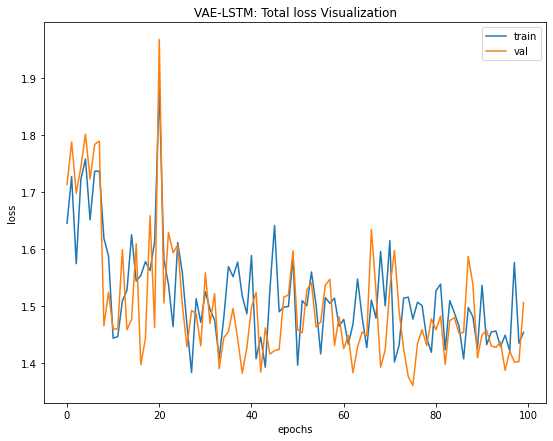

In [60]:
# Visualize total training & testing losses-
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_train_loss'] for e in training_metrics.keys()], label = 'train')
plt.plot([training_metrics[e]['total_test_loss'] for e in training_metrics.keys()], label = 'val')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE-LSTM: Total loss Visualization")
plt.legend(loc = 'best')
plt.show()

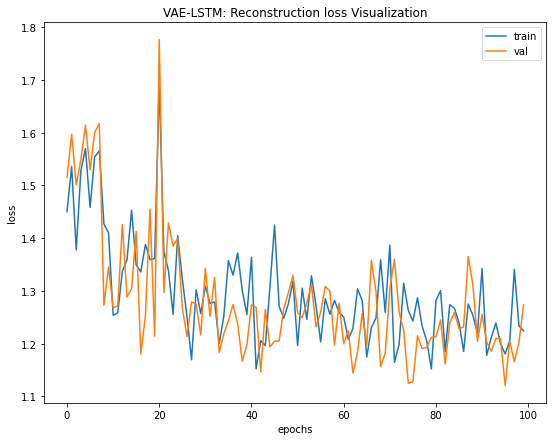

In [61]:
# Visualize training & testing reconstruction losses-
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['train_recon_loss'] for e in training_metrics.keys()], label = 'train')
plt.plot([training_metrics[e]['val_recon_loss'] for e in training_metrics.keys()], label = 'val')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE-LSTM: Reconstruction loss Visualization")
plt.legend(loc = 'best')
plt.show()

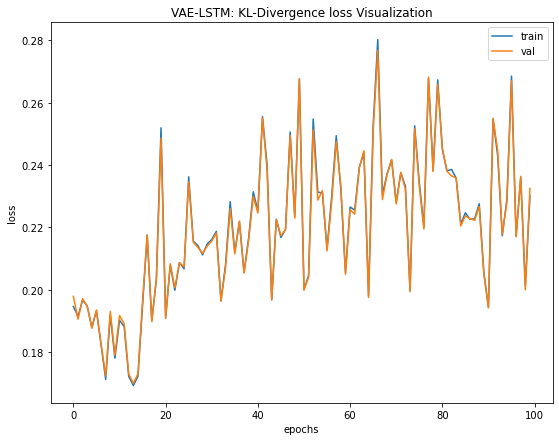

In [62]:
# Visualize training & testing KL-divergence losses-
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['train_kl_loss'] for e in training_metrics.keys()], label = 'train')
plt.plot([training_metrics[e]['val_kl_loss'] for e in training_metrics.keys()], label = 'val')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE-LSTM: KL-Divergence loss Visualization")
plt.legend(loc = 'best')
plt.show()

In [63]:
# Delete trained model above as it overfits-
del model

In [64]:
# Initialize and load 'best' parameters from before-
model_vae_lstm_best = VAE_LSTM(latent_space = 7)

In [65]:
# Get a batch of training data-
x, y = next(iter(train_dataset))

In [66]:
# Get model predictions-
y_recon, mu, log_var = model_vae_lstm_best(x)

In [67]:
# Sanity check-
y_recon.shape, y.shape

(TensorShape([256, 10, 8]), TensorShape([256, 10, 8]))

In [68]:
# Load 'best' parameters from training-
model_vae_lstm_best.load_weights("VAE_LSTM-household_consumption.h5")

In [69]:
del x, y

In [70]:
# Python3 lists to contain predictions-
predictions = []
predictions_mu = []
predictions_log_var = []

In [71]:
for x_t, y_t in test_dataset:
    x_t_recon, mu, log_var = model_vae_lstm_best(x_t)
    predictions.append(x_t_recon)
    predictions_mu.append(mu)
    predictions_log_var.append(log_var)

In [72]:
# Convert from Python3 list to np arrays-
predictions = np.vstack(predictions)

In [73]:
# Sanity check-
predictions.shape, y_test.shape

((207360, 10, 8), (207487, 10, 8))

In [74]:
predictions_mu = np.vstack(predictions_mu)
predictions_log_var = np.vstack(predictions_log_var)

In [75]:
predictions_mu.shape, predictions_log_var.shape

((6220800, 7), (6220800, 7))

### Compare _true_ vs. _predicted_ values

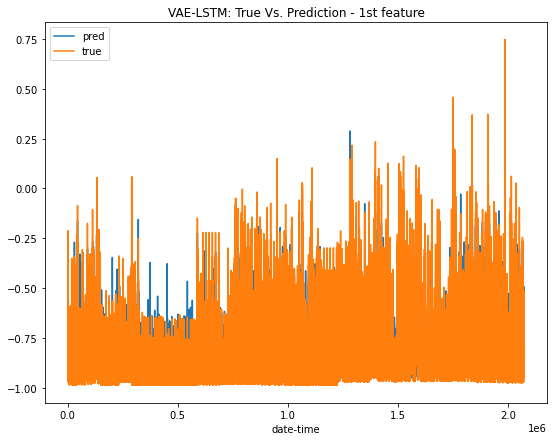

In [76]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 0].flatten(), label = 'pred')
plt.plot(y_test[:, :, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM: True Vs. Prediction - 1st feature")
plt.legend(loc = 'best')
plt.show()

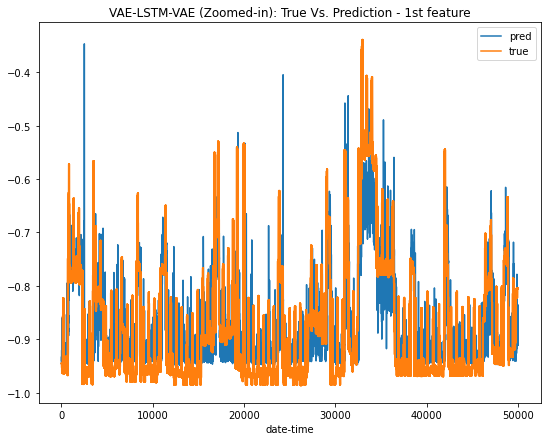

In [77]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[20000:25000, :, 0].flatten(), label = 'pred')
plt.plot(y_test[20000:25000, :, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM-VAE (Zoomed-in): True Vs. Prediction - 1st feature")
plt.legend(loc = 'best')
plt.show()

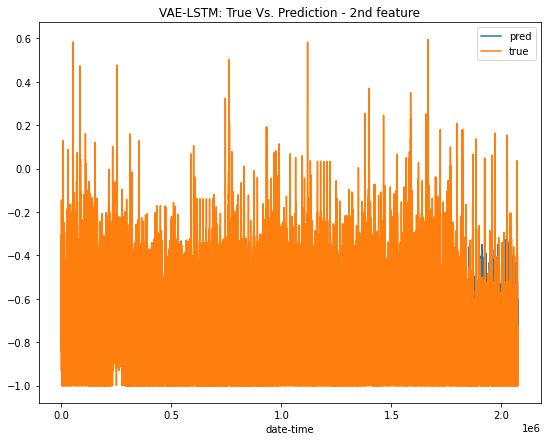

In [78]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 1].flatten(), label = 'pred')
plt.plot(y_test[:, :, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM: True Vs. Prediction - 2nd feature")
plt.legend(loc = 'best')
plt.show()

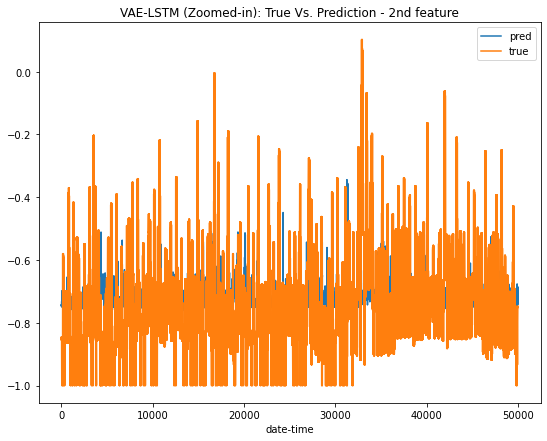

In [79]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[20000:25000, :, 1].flatten(), label = 'pred')
plt.plot(y_test[20000:25000, :, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM (Zoomed-in): True Vs. Prediction - 2nd feature")
plt.legend(loc = 'best')
plt.show()

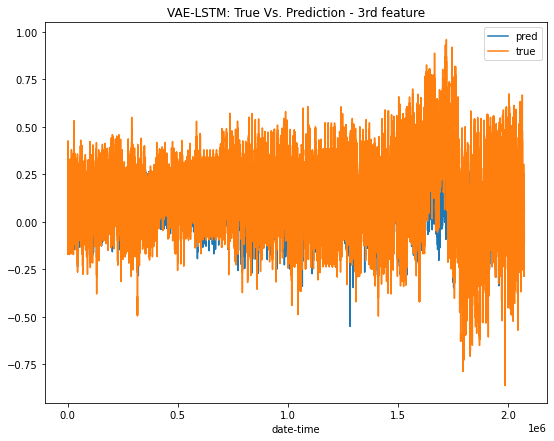

In [80]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 2].flatten(), label = 'pred')
plt.plot(y_test[:, :, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM: True Vs. Prediction - 3rd feature")
plt.legend(loc = 'best')
plt.show()

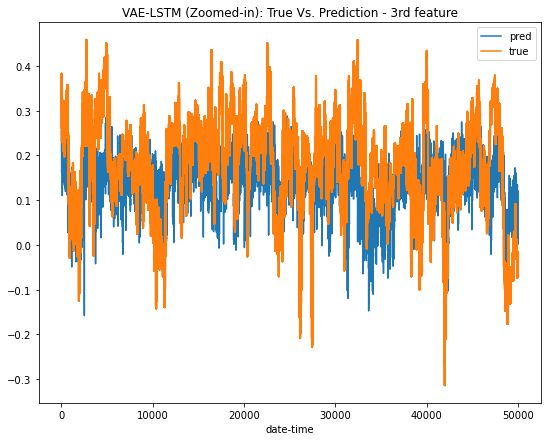

In [81]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[20000:25000, :, 2].flatten(), label = 'pred')
plt.plot(y_test[20000:25000, :, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM (Zoomed-in): True Vs. Prediction - 3rd feature")
plt.legend(loc = 'best')
plt.show()

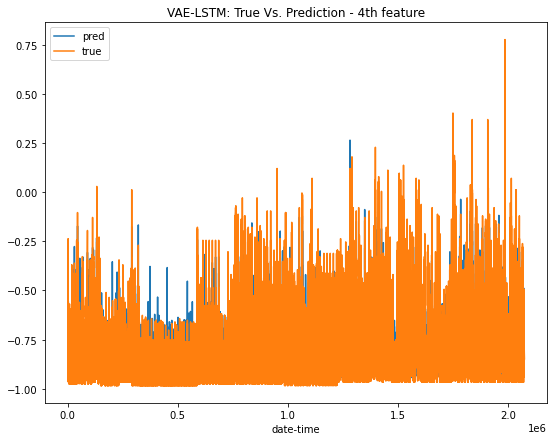

In [82]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 3].flatten(), label = 'pred')
plt.plot(y_test[:, :, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM: True Vs. Prediction - 4th feature")
plt.legend(loc = 'best')
plt.show()

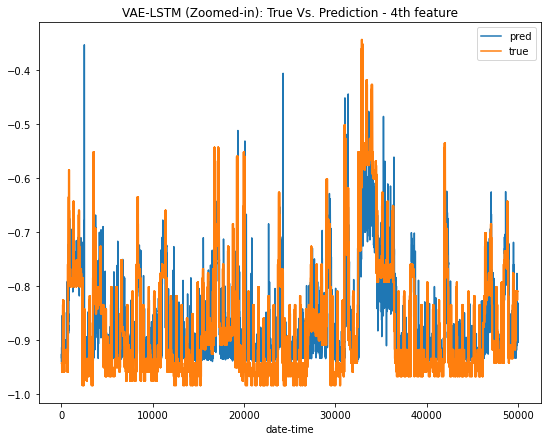

In [83]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[20000:25000, :, 3].flatten(), label = 'pred')
plt.plot(y_test[20000:25000, :, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM (Zoomed-in): True Vs. Prediction - 4th feature")
plt.legend(loc = 'best')
plt.show()

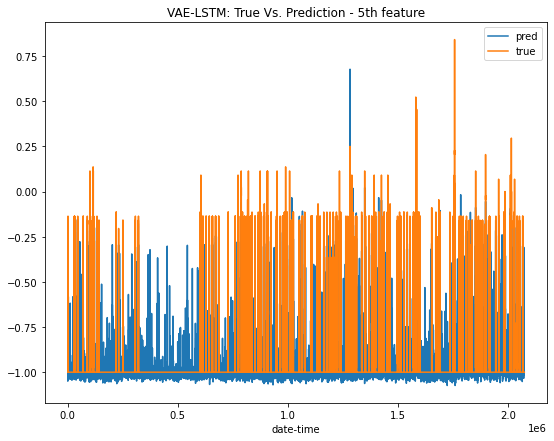

In [84]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 4].flatten(), label = 'pred')
plt.plot(y_test[:, :, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM: True Vs. Prediction - 5th feature")
plt.legend(loc = 'best')
plt.show()

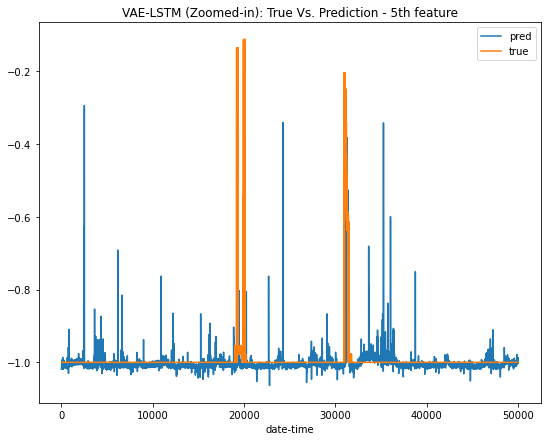

In [85]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[20000:25000, :, 4].flatten(), label = 'pred')
plt.plot(y_test[20000:25000, :, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM (Zoomed-in): True Vs. Prediction - 5th feature")
plt.legend(loc = 'best')
plt.show()

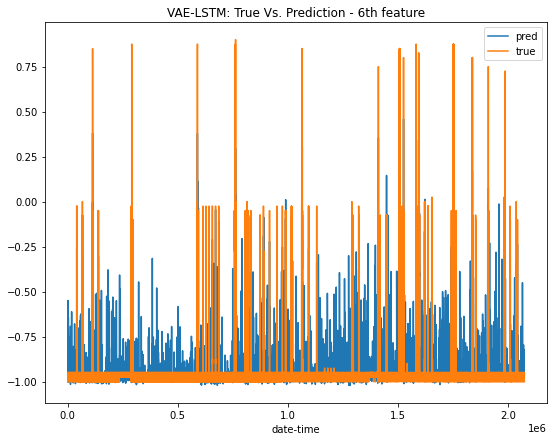

In [86]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 5].flatten(), label = 'pred')
plt.plot(y_test[:, :, 5].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM: True Vs. Prediction - 6th feature")
plt.legend(loc = 'best')
plt.show()

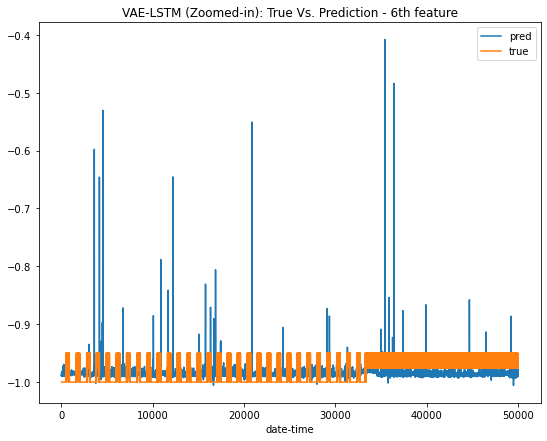

In [87]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[20000:25000, :, 5].flatten(), label = 'pred')
plt.plot(y_test[20000:25000, :, 5].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM (Zoomed-in): True Vs. Prediction - 6th feature")
plt.legend(loc = 'best')
plt.show()

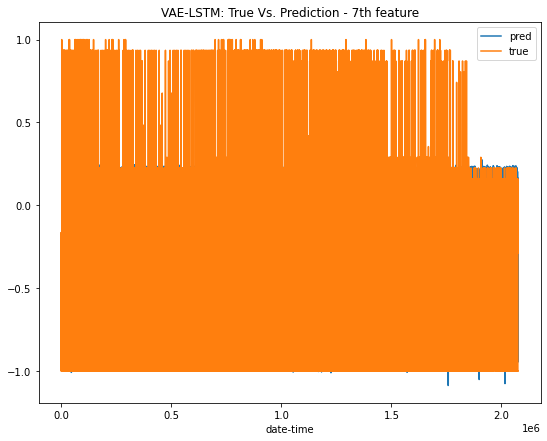

In [88]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 6].flatten(), label = 'pred')
plt.plot(y_test[:, :, 6].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM: True Vs. Prediction - 7th feature")
plt.legend(loc = 'best')
plt.show()

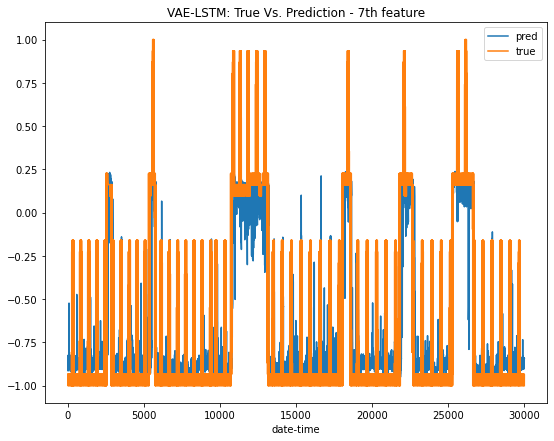

In [89]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[12000:15000, :, 6].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 6].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM: True Vs. Prediction - 7th feature")
plt.legend(loc = 'best')
plt.show()

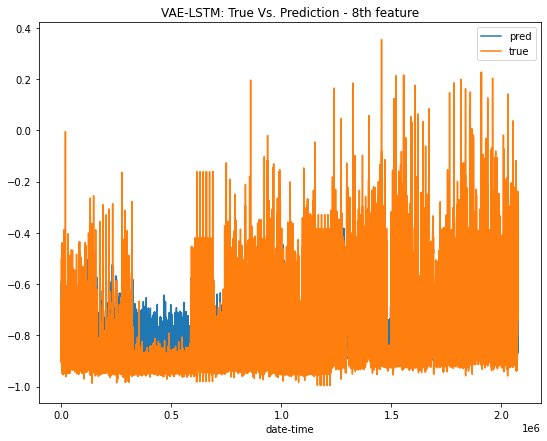

In [90]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 7].flatten(), label = 'pred')
plt.plot(y_test[:, :, 7].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM: True Vs. Prediction - 8th feature")
plt.legend(loc = 'best')
plt.show()

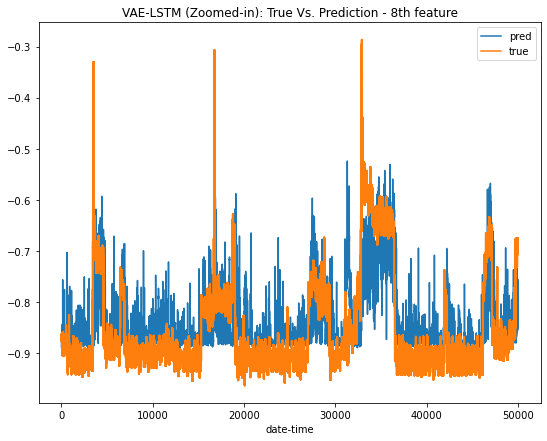

In [91]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[20000:25000, :, 7].flatten(), label = 'pred')
plt.plot(y_test[20000:25000, :, 7].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("VAE-LSTM (Zoomed-in): True Vs. Prediction - 8th feature")
plt.legend(loc = 'best')
plt.show()

### Future actions

To possible improve the performance, you might experiment with:

- Increasing _reconstruction loss_ weightage to increase its weightage.
- Experiment with: _GRU, Bidirectional layers_, different number of LSTM cells, etc.
- Different values for: _look-back window, look-ahead_.
- Use _learning-rate scheduler_, early-stopping (when LR-scheduler is not used).

### Latent space analyis

In [93]:
predictions_mu.shape, predictions_log_var.shape

((6220800, 7), (6220800, 7))

In [94]:
print("mean vector, latent space (ls):")
for i in range(7):
    print(f"ls: {i + 1}; mean = {predictions_mu[i].mean():.4f} &"
          f" standard deviation = {predictions_mu[i].std():.4f}")

mean vector, latent space (ls):
ls: 1; mean = 0.0552 & standard deviation = 0.1059
ls: 2; mean = 0.0541 & standard deviation = 0.1066
ls: 3; mean = 0.0556 & standard deviation = 0.1062
ls: 4; mean = 0.0591 & standard deviation = 0.1119
ls: 5; mean = 0.0654 & standard deviation = 0.1222
ls: 6; mean = 0.0565 & standard deviation = 0.1076
ls: 7; mean = 0.0663 & standard deviation = 0.1237


In [95]:
print("log-variance vector, latent space (ls):")
for i in range(7):
    print(f"ls: {i + 1}; mean = {predictions_log_var[i].mean():.4f} &"
          f" standard deviation = {predictions_log_var[i].std():.4f}")

log-variance vector, latent space (ls):
ls: 1; mean = 0.0070 & standard deviation = 0.1197
ls: 2; mean = 0.0050 & standard deviation = 0.1201
ls: 3; mean = 0.0073 & standard deviation = 0.1194
ls: 4; mean = 0.0087 & standard deviation = 0.1161
ls: 5; mean = 0.0110 & standard deviation = 0.1104
ls: 6; mean = 0.0077 & standard deviation = 0.1186
ls: 7; mean = 0.0114 & standard deviation = 0.1096


In [98]:
# Compute number of bins-
num_bins = int(np.ceil(np.sqrt(len(predictions_mu))))
print(f"number of bins using rule of thumb = {num_bins}")

number of bins using rule of thumb = 2495


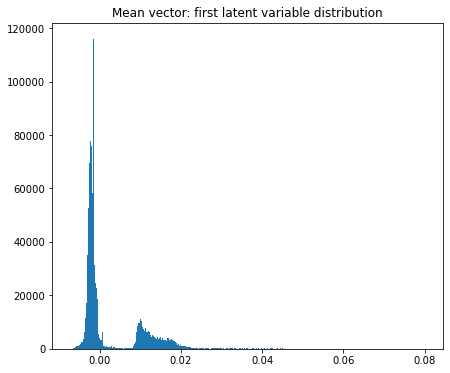

In [101]:
plt.figure(figsize = (7, 6))
plt.hist(predictions_mu[:, 0], bins = num_bins)
plt.title("Mean vector: first latent variable distribution")
plt.show()

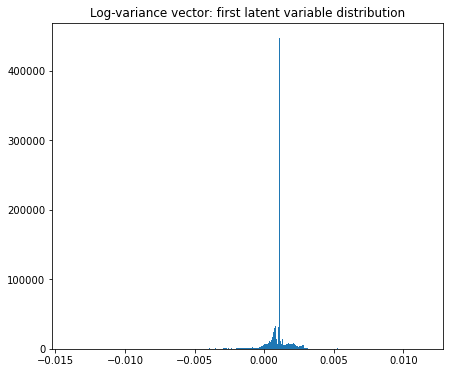

In [111]:
plt.figure(figsize = (7, 6))
plt.hist(predictions_log_var[:, 0], bins = num_bins)
plt.title("Log-variance vector: first latent variable distribution")
plt.show()

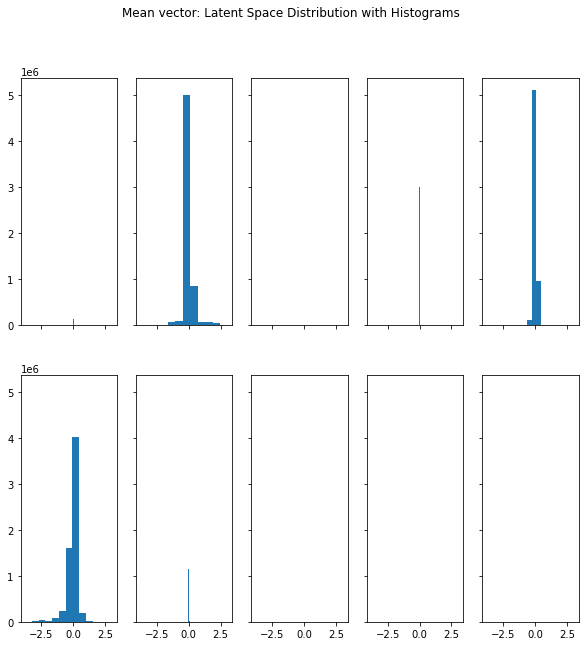

In [110]:
fig, axes = plt.subplots(
    nrows = 2, ncols = 5,
    sharex = True, sharey = True,
    figsize = (10, 10)
)

i = 0
for row in range(len(axes)):
    for col in range(len(axes[0])):
        if i >= 7:
            break
        axes[row][col].hist(predictions_mu[:, i])
        i += 1

plt.suptitle("Mean vector: Latent Space Distribution with Histograms")
plt.show()